Author: Sigrid Bom Nielsen

Created in May, 2024

# 1. Data wrangling

Objective of project: 
- We want to predict 'Age of death' (lifespan) by using the features of 'Birth year', 'Gender', 'Country' and 'Occupation'. 
- There's a few text columns which need to be embedded. We'll go through the variables one by one.

Objective of script: 
- Get an overview of data and relevant features.
- Potentially recode the features so that they are ready to be embedded or plotted directly into a model
- Split data into training, validation and test sets (without spilling information between sets).

Briefly about the data:
- The data is found can be found here https://www.kaggle.com/datasets/imoore/age-dataset 
- The data has been scraped from wikipedia.
- The dataset consists mainly of text and has many rows (> 1 million) (before removing NAs, etc).

Credits: Annamoradnejad, Issa; Annamoradnejad, Rahimberdi (2022), “Age dataset: A structured general-purpose dataset on life, work, and death of 1.22 million distinguished people”, In Workshop Proceedings of the 16th International AAAI Conference on Web and Social Media (ICWSM), doi: 10.36190/2022.82

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import wordcloud
from collections import Counter

### Overview of dataset and removing NAs from relevant columns

In [3]:
#data = pd.read_csv('/work/datascience_exam/data/AgeDataset-V1.csv')
data = pd.read_csv('../../data/AgeDataset-V1.csv')
data.head()

,Id,Name,Short description,Gender,Country,Occupation,Birth year,Death year,Manner of death,Age of death
0,Q23,George Washington,1st president of the United States (1732–1799),Male,United States of America; Kingdom of Great Bri...,Politician,1732,1799.0,natural causes,67.0
1,Q42,Douglas Adams,English writer and humorist,Male,United Kingdom,Artist,1952,2001.0,natural causes,49.0
2,Q91,Abraham Lincoln,16th president of the United States (1809-1865),Male,United States of America,Politician,1809,1865.0,homicide,56.0
3,Q254,Wolfgang Amadeus Mozart,Austrian composer of the Classical period,Male,Archduchy of Austria; Archbishopric of Salzburg,Artist,1756,1791.0,NaN,35.0
4,Q255,Ludwig van Beethoven,German classical and romantic composer,Male,Holy Roman Empire; Austrian Empire,Artist,1770,1827.0,NaN,57.0


In [5]:
data.shape

(1223009, 10)

Without removing NAs, we have 1.223.009 rows.

In [4]:
#overview of NAs
data.isna().sum()

Id                         0
Name                       0
Short description      67900
Gender                133646
Country               335509
Occupation            206914
Birth year                 0
Death year                 1
Manner of death      1169406
Age of death               1
dtype: int64

But we have a lot of NAs. We'll start by removing NAs from the relevant columns. 

In [5]:
data = data.dropna(subset = ['Short description', 'Gender', 'Country', 'Occupation', 'Birth year', 'Age of death']) #'Short description'])

In [6]:
data.isna().sum()

Id                        0
Name                      0
Short description         0
Gender                    0
Country                   0
Occupation                0
Birth year                0
Death year                0
Manner of death      687133
Age of death              0
dtype: int64

In [9]:
data= data.filter(items = ['Gender', 'Country', 'Occupation', 'Birth year', 'Age of death', 'Short description'])

In [10]:
data.head()

,Gender,Country,Occupation,Birth year,Age of death,Short description
0,Male,United States of America; Kingdom of Great Bri...,Politician,1732,67.0,1st president of the United States (1732–1799)
1,Male,United Kingdom,Artist,1952,49.0,English writer and humorist
2,Male,United States of America,Politician,1809,56.0,16th president of the United States (1809-1865)
3,Male,Archduchy of Austria; Archbishopric of Salzburg,Artist,1756,35.0,Austrian composer of the Classical period
4,Male,Holy Roman Empire; Austrian Empire,Artist,1770,57.0,German classical and romantic composer


In [11]:
data.shape

(732961, 6)

Now we're down to 735.785 rows. 

## Inspecting and potentially recoding variables
No data will transfer from columns because I'm not standardizing, I'm recoding the values of columns to make them easier to work with.

### 'Gender' variable

In [12]:
data["Gender"].value_counts()

Gender
Male                                              659548
Female                                             73286
Transgender Female                                    57
Transgender Male                                      30
Eunuch; Male                                          13
Intersex                                               7
Female; Male                                           5
Transgender Male; Female                               3
Non-Binary                                             2
Female; Female                                         1
Transgender Female; Intersex                           1
Eunuch                                                 1
Transgender Male; Male                                 1
Transgender Female; Female                             1
Intersex; Transgender Male                             1
Transgender Female; Male                               1
Intersex; Male                                         1
Transgender Person; Inte

Most rows are either 'Male' or 'Female', while a small handfull of rows are more gender-fluid (except for one column being labelled 'Female; Female'). To make modelling easier, we'll encode a new gender column, where 1 = 'Male, 2 = 'Female' and 3 = 'Other'.

In [13]:
def map_gender(value):
    #if value in ['Male', 'Eunuch', 'Eunuch; Male']:
    if value == 'Male':
        return 1
    elif value in ['Female', 'Female; Female']:
        return 2
    else:
        return 3

In [14]:
# Apply the function to the 'gender_column' and store the results in a new column 'gender_encode'
data.loc[:,'Gender_encode'] = data['Gender'].apply(map_gender)
data["Gender_encode"].value_counts()

Gender_encode
1    659548
2     73287
3       126
Name: count, dtype: int64

In [7]:
# only for plotting purposes
gender_map = {1: 'Male', 2: 'Female', 3:'Other'}

# Create a new column with the mapped labels
data['Gender_label'] = data['Gender_encode'].map(gender_map)
data.head()

,Gender,Country,Occupation,Birth year,Age of death,Gender_encode,Gender_label
0,Male,United States of America; Kingdom of Great Bri...,Politician,1732,67.0,1,Male
1,Male,United Kingdom,Artist,1952,49.0,1,Male
2,Male,United States of America,Politician,1809,56.0,1,Male
3,Male,Archduchy of Austria; Archbishopric of Salzburg,Artist,1756,35.0,1,Male
4,Male,Holy Roman Empire; Austrian Empire,Artist,1770,57.0,1,Male


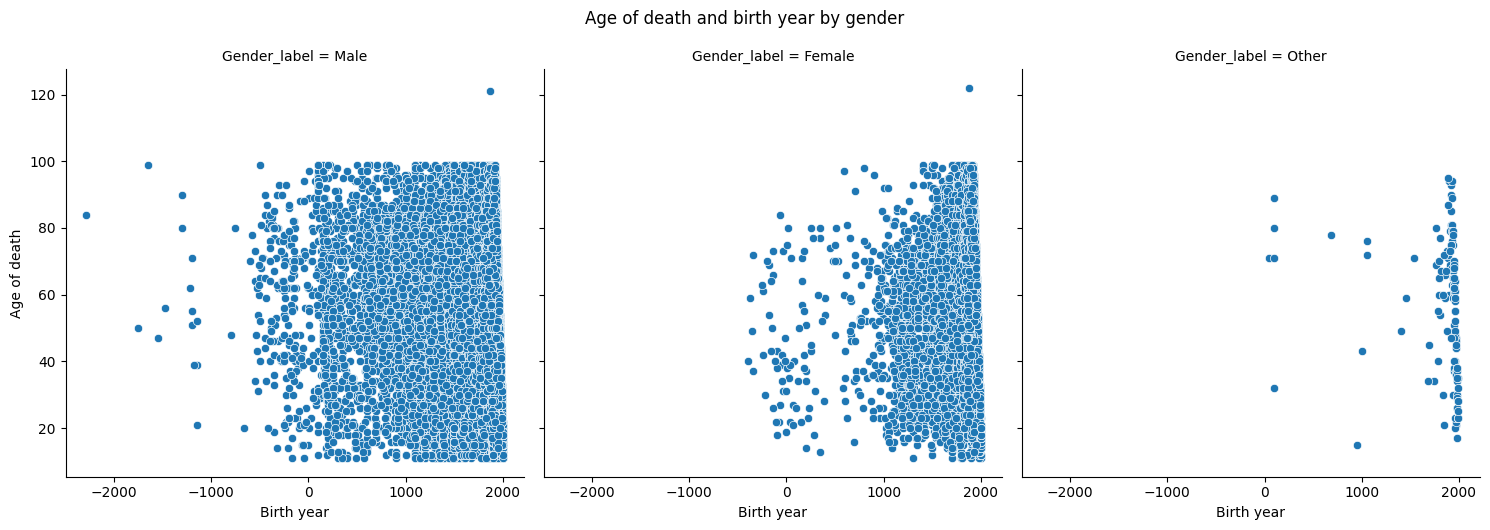

In [17]:
# Plotting encoded gender, birth year and age of death
p = sns.relplot(
    data=data,
    x="Birth year", y="Age of death", 
    col="Gender_label"
    )

plt.suptitle("Age of death and birth year by gender", y = 1.05)
#plt.gcf()
plt.show()

In [122]:
# save fig - change gender_encode title first (male, female, other)
p.savefig('/work/datascience_exam/output/plots/gender_overview.jpg')

/tmp/ipykernel_5112/1618606778.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Gender_encode', y='Age of death', data=data, palette='viridis')


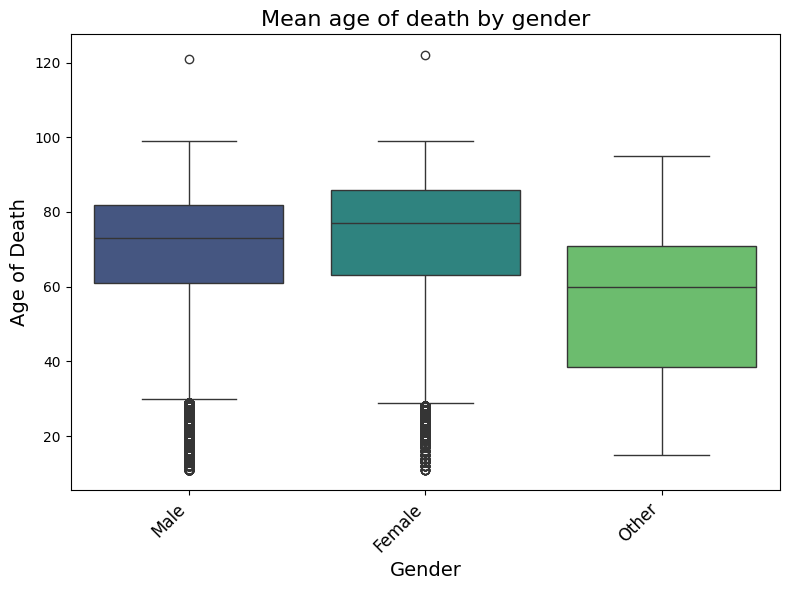

In [116]:
#### boxplot of mean age of death in gender
#The 'whiskers' are quartiles of the data and the points are outliers (determined by the boxplot function)

# Plotting with Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Gender_encode', y='Age of death', data=data, palette='viridis')

# Adding titles and labels
plt.title('Mean age of death by gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Age of Death', fontsize=14)
plt.xticks([0,1,2], ['Male', 'Female', 'Other'], rotation = 45, ha = 'right', fontsize = 12)

# Display the plot
plt.tight_layout()
fig = plt.gcf() # get current figure
plt.show()

In [73]:
# save fig
fig.savefig('/work/datascience_exam/output/plots/mean_age_gender.jpg')

### 'Birth year' variable


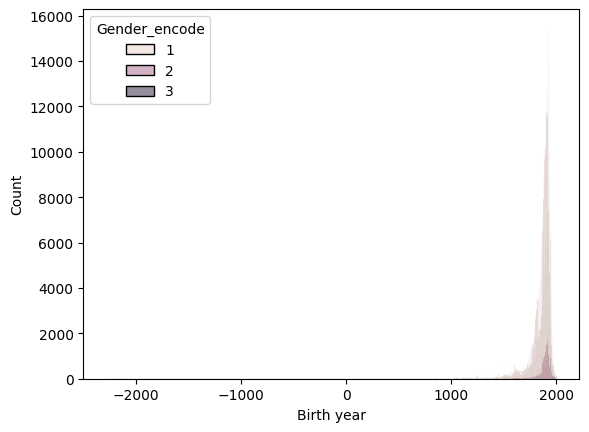

In [18]:
sns.histplot(data = data, x = 'Birth year', hue = 'Gender_encode')
#plt.legend(title = "Gender", loc = "upper left", labels = ["Other", "Female", "Male"])
plt.show()



### 'Country' variable
This column contains many different labels, because countries have changed their names throughout time and because some people might belong to different countries. So, we want to embed this column. 

- consider only including countries with a certain number of famous people?? 

In [15]:
data["Country"].value_counts()

Country
United States of America                                       145078
Germany                                                         78694
France                                                          64165
United Kingdom; United Kingdom of Great Britain and Ireland     28257
United Kingdom                                                  21270
                                                                ...  
Qing dynasty; Hongkongers                                           1
Sui dynasty; Tang Empire; Chen dynasty; Liang dynasty               1
United States of America; France; Kingdom of Italy                  1
France; Portugalete Canton                                          1
Syria; State of Syria; Syrian Republic                              1
Name: count, Length: 5505, dtype: int64

In [16]:
len(data["Country"]) # 735,785

732961

In [17]:
len(data['Country'].unique())

5505

5,522 unique rows.
I have eyeballed some labels, which could be combined. But we'll see to that later.
Now, we want to preprocess the text so that it is ready to be embedded.

#### Preprocessing for embeddings - transform letters to lowercase
- Make function, because we are going to need it later

In [18]:
def lowercase(data, column_name):
    column_list = data[column_name].tolist()

    column_list_lower = []
    for idx in range(0,len(column_list)):
        temp = column_list[idx].lower()
        column_list_lower += [temp]
    
    data.loc[:,column_name] = column_list_lower
    
    return(data, column_list_lower)

In [29]:
# applying function
data, country_list = lowercase(data, 'Country')

#### make wordcloud

In [32]:
word_list_country = [word.strip() for sublist in data['Country'].str.split(';') for word in sublist]
len(word_list_country) # we know have 100,000 more rows, because some rows/persons have two countries listed 
count_country = Counter(word_list_country)
#len(count_country)
#count_country.most_common(50)
# consider cleaning - adding some columns together 
#sorted(count_country.items())

(-0.5, 1599.5, 799.5, -0.5)

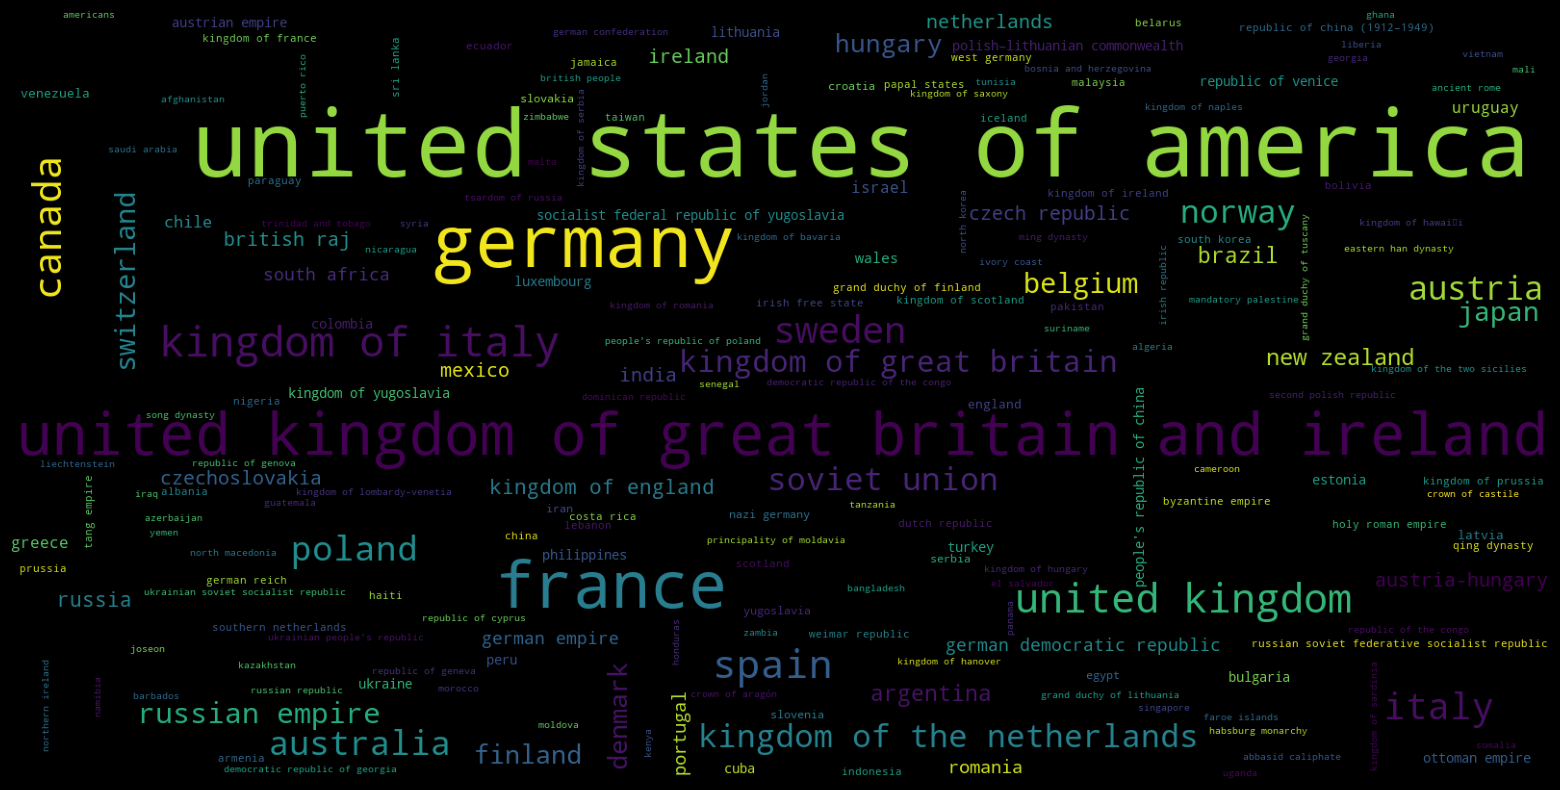

In [76]:
wordcloud_country = wordcloud.WordCloud(width=1600, height=800).generate_from_frequencies(count_country)
#plt.tight_layout(pad = 0)

plt.figure( figsize=(20,10), facecolor = 'k')
plt.gcf()
plt.imshow(wordcloud_country)#, interpolation='bilinear')
plt.axis("off")

#plt.show()

In [78]:
# save wordcloud
wordcloud_country.to_file("/work/datascience_exam/output/plots/wordcloud_country.png")

In [14]:
# manually fixing some countries, which are the same
# concatenate some columns
data["Country"] = data["Country"].str.replace('united kingdom; united kingdom of great britain and ireland','united kingdom of great britain and ireland')

In [15]:
len(data["Country"].unique())

5505

5,505 unique rows

#### Mean age of death in different countries
Make boxplot of mean age of death in most common countries. 

In [23]:
# make plot with mean age of death in 20 most common countries
country_list = data['Country'].to_list()
count = Counter(country_list)
count.most_common(20)

[('united states of america', 145078),
 ('germany', 78694),
 ('france', 64165),
 ('united kingdom of great britain and ireland', 45558),
 ('united kingdom', 21270),
 ('canada', 20985),
 ('spain', 20496),
 ('sweden', 18580),
 ('italy; kingdom of italy', 15217),
 ('poland', 14089),
 ('norway', 13526),
 ('australia', 13454),
 ('kingdom of the netherlands', 13444),
 ('austria', 12552),
 ('belgium', 9814),
 ('switzerland', 9317),
 ('japan', 9314),
 ('kingdom of italy', 8619),
 ('finland', 8353),
 ('denmark', 8293)]

In [25]:
selected_countries = ['united states of america,' 'germany', 'france', 'united kingdom', 'united kingdom of great britain and ireland', 'canada', 'spain', 
                    'sweden', 'italy', 'italy: kingdom of italy', 'poland', 'norway', 'kingdom of the netherlands', 'australia', 'austria', 'belgium',
                    'japan', 'switzerland', 'kingdom of italy', 'denmark', 'finland']

In [26]:
filtered_data = data[data['Country'].isin(selected_countries)]

/tmp/ipykernel_5112/1576162892.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Country', y='Age of death', data=filtered_data, palette='viridis')


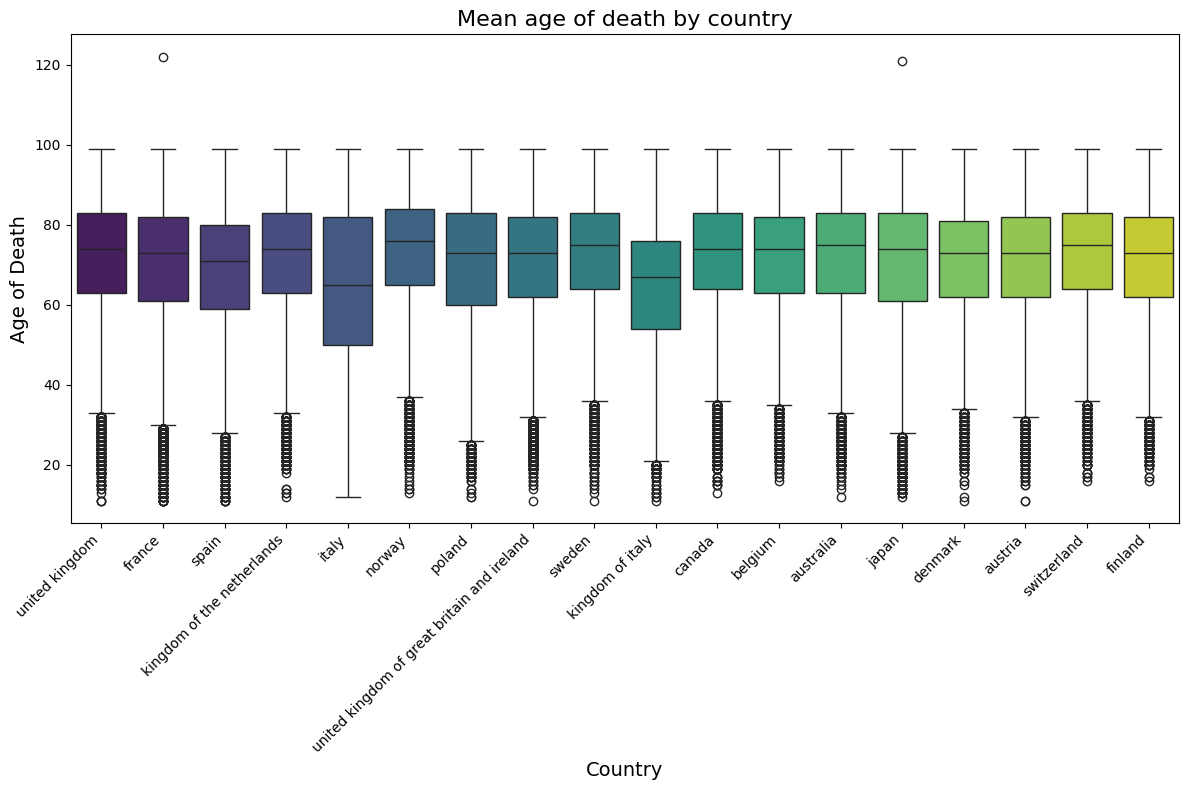

In [27]:
# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(x='Country', y='Age of death', data=filtered_data, palette='viridis')

# Adding titles and labels
plt.title('Mean age of death by country', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Age of Death', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
fig = plt.gcf() # get current figure
plt.show()

In [ ]:
# save figure
fig.savefig('/work/datascience_exam/output/plots/mean_age_country.jpg')

### 'Occupation' variable
"Occupation" also spans wide with 7,820 unique rows. We want to embed that column, too. But first, we want to know how many rows have more than one string. 

In [28]:
data["Occupation"].value_counts()
#data["Occupation"].unique().tolist()

Occupation
Artist                                    207322
Politician                                152916
Athlete                                    92645
Researcher                                 63799
Military personnel                         36025
                                           ...  
Feminism                                       1
Pedagogue; violinist; music pedagogue          1
Muezzin; terrorist                             1
Médaille de la résistance                      1
Clarinet; clarinetist; music pedagogue         1
Name: count, Length: 7750, dtype: int64

In [31]:
len(data['Occupation'].unique())

7750

In [19]:
# applying function
data, occupation_list = lowercase(data, 'Occupation')

#### Wordcloud

In [ ]:
word_list_occupation = [word.strip() for sublist in data['Occupation'].str.split(';') for word in sublist]
count_occupation = Counter(word_list_occupation)
count_occupation.most_common(20)

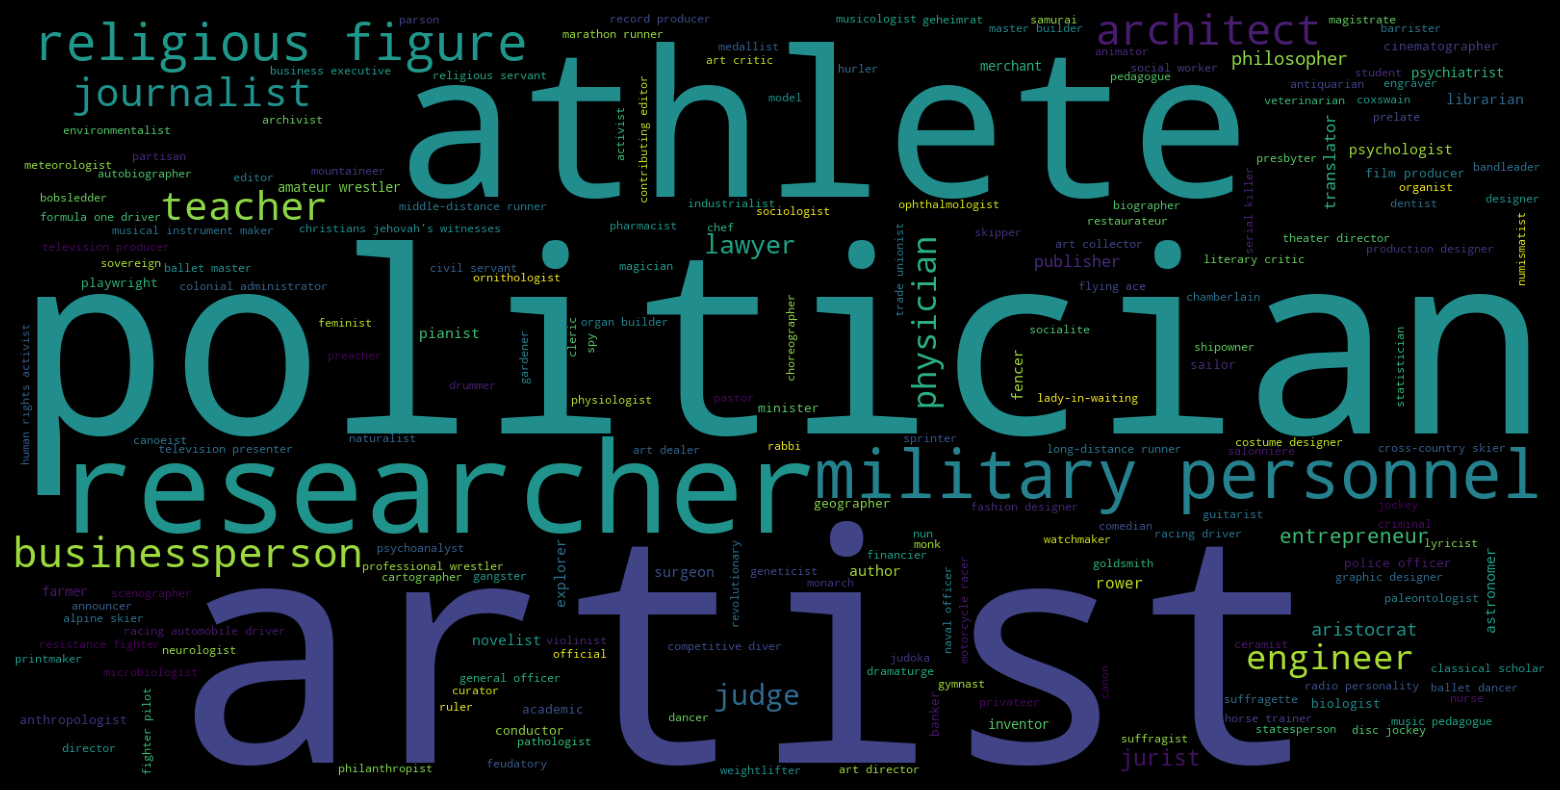

In [79]:
wordcloud_occupation = wordcloud.WordCloud(width=1600, height=800).generate_from_frequencies(count_occupation)

#plt.tight_layout(pad = 0)
plt.figure( figsize=(20,10), facecolor = 'k')
plt.imshow(wordcloud_occupation)#, interpolation='bilinear')
plt.axis("off")
plt.gcf()
plt.show()

In [80]:
# save wordcloud
wordcloud_country.to_file("/work/datascience_exam/output/plots/wordcloud_occupation.png")

#### Mean age of death in different occupations
Make boxplot of mean age of death in most common occupations

In [34]:
count = Counter(occupation_list)
count.most_common(20)

[('artist', 207322),
 ('politician', 152916),
 ('athlete', 92645),
 ('researcher', 63799),
 ('military personnel', 36025),
 ('religious figure', 18538),
 ('architect', 12588),
 ('businessperson', 12108),
 ('journalist', 10929),
 ('teacher', 10769),
 ('engineer', 8257),
 ('physician', 7538),
 ('judge', 5702),
 ('lawyer', 4453),
 ('jurist', 2796),
 ('entrepreneur', 2501),
 ('aristocrat', 2040),
 ('translator', 1747),
 ('publisher', 1711),
 ('philosopher', 1691)]

In [35]:
selected_occupations1 = ['artist', 'politician', 'athlete', 'researcher', 'military personnel', 'religious figure', 'architect', 
                        'businessperson', 'journalist', 'teacher', 'engineer', 'physician', 'judge', 'lawyer', 'jurist', 'entrepreneur', 
                        'aristocrat', 'translator', 'publisher', 'philosopher', 'rover', 'librarian', 'astronomer', 'fencer', 'psychologist', 'novelist', 'surgeon', 'pianist', 'merchant', 'author', 
                        'amateur wrestler', 'farmer', 'explorer', 'inventor', 'minister', 'sailor', 'film producer', 'psychiatrist','cinematographer', 'police officer']

In [36]:
selected_occupations2 = ['flying ace', 
                         'anthropologist', 'banker', 'academic', 'geographer', 'rabbi', 'biologist', 'civil servant', 'trade unionist','playwright', 'nun', 'organist', 'samurai', 'sprinter', 'designer', 
                        'naval officer','graphic designer','archivist', 'conductor', 'canoeist', 'pharmacist', 'organ builder', 'radio personality', 'activist', 'presbyter', 'sovereign', 'official',
                        'pastor', 'partisan', 'theater director', 'monarch','revolutionary', 'motorcycle racer', 'veterinarian', 'alpine skier', 'jockey', 'guitarist', 'ruler', 'magistrate', 'monk']

In [37]:
selected_occupations3 = ['business executive', 'ballet dancer', 'nurse', 'cross-country skier', 'television presenter', 'professional wrestler', 'lady-in-waiting', 
                        'prelate', 'dentist', 'art collector', 'bobsledder', 'scenographer', 'weightlifter', 'serial killer', 'curator', 'skipper', 'ornithologist', 
                        'sociologist', 'racing automobile driver', 'mountaineer', 'drummer', 'socialite', 'philanthropist', 'engraver', 'christians jehovah’s witnesses', 
                        'meteorologist', 'hurler', 'parson', 'general officer', 'horse trainer', 'medallist', 'editor', 'spy', 'art dealer', 'marathon runner', 'numismatist', 
                        'preacher', 'racing driver', 'lyricist', 'cleric']

In [38]:
filtered_data = data[data['Occupation'].isin(selected_occupations3)] #CHANGE HERE

In [39]:
mean_age_of_death = filtered_data.groupby('Occupation')['Age of death'].mean().reset_index()

In [40]:
# Define the specific list of row strings in the desired order
specific_order = selected_occupations3 # CHANGE HERE

# Create a dictionary to store the index of each name in the specific order
name_index = {name: i for i, name in enumerate(specific_order)}

# Create a function to get the index from the specific order for each name
def get_index(name):
    return name_index.get(name, float('inf'))

# Create a new column with the order based on the specific list
filtered_data.loc[:,'Order'] = filtered_data['Occupation'].apply(get_index)

# Sort the DataFrame based on the new 'Order' column and original index to maintain the original order of rows with the same name
data_sorted = filtered_data.sort_values(by=['Order'])#, filtered_data.index])

# Drop the 'Order' column if it's no longer needed
#data_sorted = data_sorted.drop(columns=['Order'])
data_sorted.head()

/tmp/ipykernel_5112/1062238439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:,'Order'] = filtered_data['Occupation'].apply(get_index)


,Short description,Gender,Country,Occupation,Birth year,Age of death,Gender_encode,Order
880035,shipping executive,Male,united kingdom,business executive,1925,75.0,1,0
843599,company director,Male,united kingdom of great britain and ireland,business executive,1848,74.0,1,0
487577,schwedischer Unternehmensleiter,Male,sweden,business executive,1838,88.0,1,0
487633,schwedischer Geschäftsmann,Male,sweden,business executive,1844,72.0,1,0
1086272,schwedischer Unternehmensleiter,Male,sweden,business executive,1878,81.0,1,0


/tmp/ipykernel_5112/2051147240.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Occupation', y='Age of death', data=data_sorted, palette='viridis')


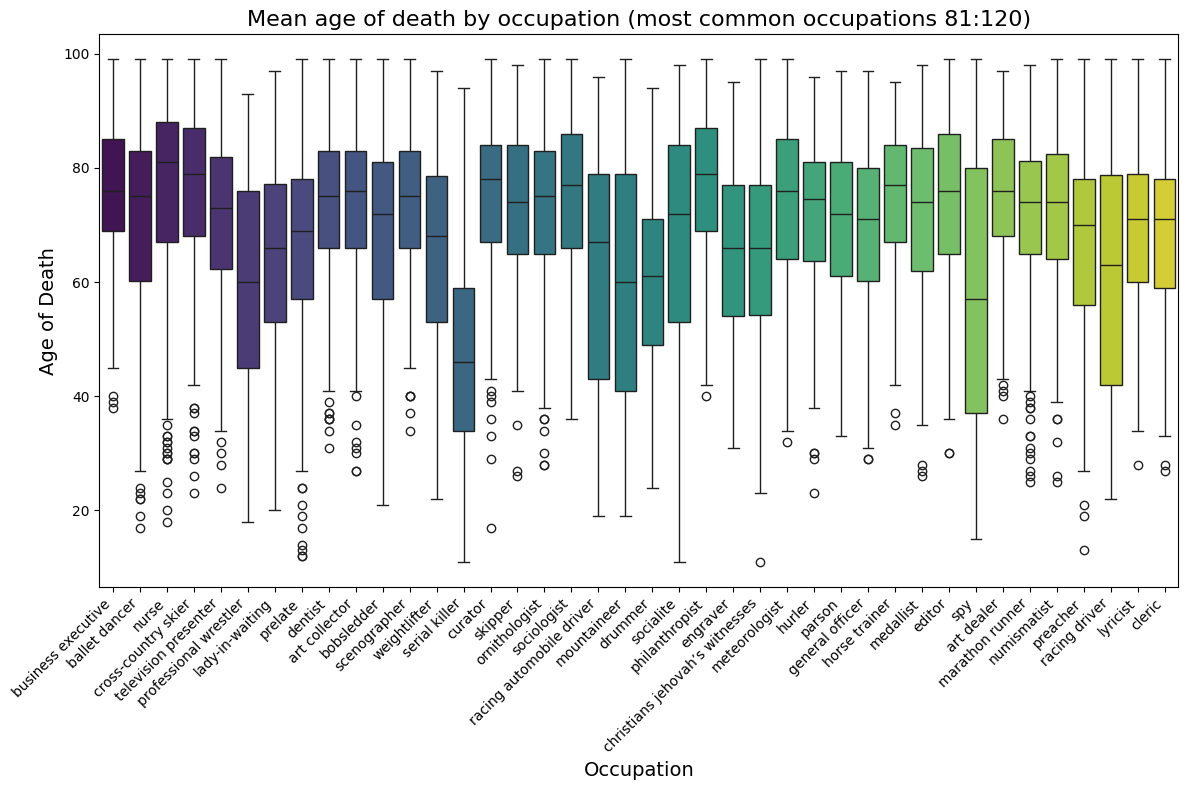

In [41]:
# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(x='Occupation', y='Age of death', data=data_sorted, palette='viridis')

#ax = sns.boxplot(x='Occupation', y='Age of death', data=filtered_data, palette='viridis')


# Adding the mean values on top of each boxplot
#for i in range(len(mean_age_of_death)):
 #   occupation = mean_age_of_death['Occupation'][i]
  #  mean_age = mean_age_of_death['Age of death'][i]
  #  x = selected_occupations.index(occupation)
  #  y = mean_age
  #  ax.text(x, y + 0.5, f'{mean_age:.2f}', ha='center', va='bottom', fontsize=10, color='black')

# Adding titles and labels
plt.title('Mean age of death by occupation (most common occupations 81:120)', fontsize=16)
plt.xlabel('Occupation', fontsize=14)
plt.ylabel('Age of Death', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
fig = plt.gcf() # get current figure
plt.show()

In [ ]:
#fig.savefig('/work/datascience_exam/output/plots/mean_age_occupation1.jpg')
fig.savefig('../output/plots/mean_age_occupation3.jpg') # CHANGE HERE

### Investigating number of strings in each cell

In [67]:
# Count the number of strings in each cell
string_counts = data['Occupation'].apply(lambda x: len(x.split(';')) if isinstance(x, str) else 0)

# Filter columns where the count is greater than 1
rows_with_multiple_strings = string_counts[string_counts > 1]

# Count the number of such columns
num_rows_with_multiple_strings = len(rows_with_multiple_strings)

print("Number of rows containing more than one string:", num_rows_with_multiple_strings)

Number of rows containing more than one string: 11881


In [ ]:
#rows_with_multiple_strings.index
#filtered_data = data.loc[rows_with_multiple_strings.index]

#filtered_data['Occupation'].value_counts()

#len(filtered_data['Occupation'].unique())

#filtered_data['Occupation'].to_list()

# Filter out rows with more than one string

#data = data[~data.index.isin(rows_with_multiple_strings.index)]
#len(data["Occupation"].unique())
# down to less than 2k

### 'Short description' variable 

In [30]:
data, description_list = lowercase(data, 'Short description')
data.head()

,Gender,Country,Occupation,Birth year,Age of death,Short description,Gender_encode
0,Male,united states of america; kingdom of great bri...,politician,1732,67.0,st president of the united states,1
1,Male,united kingdom,artist,1952,49.0,english writer and humorist,1
2,Male,united states of america,politician,1809,56.0,th president of the united states,1
3,Male,archduchy of austria; archbishopric of salzburg,artist,1756,35.0,austrian composer of the classical period,1
4,Male,holy roman empire; austrian empire,artist,1770,57.0,german classical and romantic composer,1


We want to remove all numbers from the column to make sure that no information is leaked. 

In [26]:
description_list

['1st president of the united states (1732–1799)',
 'english writer and humorist',
 '16th president of the united states (1809-1865)',
 'austrian composer of the classical period',
 'german classical and romantic composer',
 'french classical scholar',
 'french writer',
 'french impressionist painter (1840-1926)',
 'spanish painter (1599-1660)',
 'greek painter, sculptor and architect',
 'american singer and actor (1935–1977)',
 'italian mathematician, physicist, philosopher and astronomer',
 'chilean politician and former president (1918-2016)',
 'king of france',
 'austrian-born german politician, chancellor and führer of germany, leader of the nazi party (1889-1945)',
 'spanish princess and saint, queen consort of france',
 'dutch footballer (1921-1984)',
 'general, politician of chile (1915-2006)',
 'belarusian writer (1882-1942)',
 'czech association football player (1904-1996)',
 'american pornographic actress, later anti-porn activist',
 'jamaican singer, songwriter and musician

In [27]:
import re

# Function to remove numbers and special characters and normalize spaces
def remove_numbers_and_special_chars(text):
    # Remove numbers and special characters
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Normalize multiple spaces to a single space
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


# Remove numbers and special characters from each string in the list
cleaned_strings = [remove_numbers_and_special_chars(s) for s in description_list]

cleaned_strings

['st president of the united states',
 'english writer and humorist',
 'th president of the united states',
 'austrian composer of the classical period',
 'german classical and romantic composer',
 'french classical scholar',
 'french writer',
 'french impressionist painter',
 'spanish painter',
 'greek painter sculptor and architect',
 'american singer and actor',
 'italian mathematician physicist philosopher and astronomer',
 'chilean politician and former president',
 'king of france',
 'austrianborn german politician chancellor and fhrer of germany leader of the nazi party',
 'spanish princess and saint queen consort of france',
 'dutch footballer',
 'general politician of chile',
 'belarusian writer',
 'czech association football player',
 'american pornographic actress later antiporn activist',
 'jamaican singer songwriter and musician',
 'american astrophysicist cosmologist author and science educator',
 'th president of chile',
 'french enlightenment philosopher and encyclopdis

In [28]:
data.loc[:,"Short description"] = cleaned_strings
data.head()

,Gender,Country,Occupation,Birth year,Age of death,Short description,Gender_encode
0,Male,United States of America; Kingdom of Great Bri...,politician,1732,67.0,st president of the united states,1
1,Male,United Kingdom,artist,1952,49.0,english writer and humorist,1
2,Male,United States of America,politician,1809,56.0,th president of the united states,1
3,Male,Archduchy of Austria; Archbishopric of Salzburg,artist,1756,35.0,austrian composer of the classical period,1
4,Male,Holy Roman Empire; Austrian Empire,artist,1770,57.0,german classical and romantic composer,1


### 'Manner of death' variable

In [45]:
manner_of_death = data.dropna(subset = ["Manner of death"])
manner_of_death.head()

(45828, 10)

In [ ]:
manner_of_death, manner_of_death_list = lowercase(manner_of_death, 'Manner of death')

In [55]:
count = Counter(manner_of_death_list)
count.most_common(20)

[('natural causes', 31045),
 ('suicide', 4508),
 ('accident', 4373),
 ('homicide', 3273),
 ('capital punishment', 1770),
 ('unnatural death', 282),
 ('death in battle', 142),
 ('capital punishment; unnatural death', 62),
 ('capital punishment; homicide', 31),
 ('accident; natural causes', 29),
 ('capital punishment; suicide', 26),
 ('suicide; accident', 22),
 ('suicide; homicide', 10),
 ('homicide; homicide', 9),
 ('shipwrecking', 7),
 ('extrajudicial killing', 6),
 ('euthanasia', 6),
 ('suicide; natural causes', 6),
 ('eastern front of world war ii', 6),
 ('war', 6)]

In [56]:
# how to get the keys to easily copy
counter_dict = dict(count)

sorted_items = sorted(counter_dict.items(), key=lambda x: x[1], reverse=True)
keys_in_range = [item[0] for item in sorted_items[0:20]]
print(keys_in_range)

['natural causes', 'suicide', 'accident', 'homicide', 'capital punishment', 'unnatural death', 'death in battle', 'capital punishment; unnatural death', 'capital punishment; homicide', 'accident; natural causes', 'capital punishment; suicide', 'suicide; accident', 'suicide; homicide', 'homicide; homicide', 'shipwrecking', 'extrajudicial killing', 'euthanasia', 'suicide; natural causes', 'eastern front of world war ii', 'war']


In [57]:
selected_deaths = ['natural causes', 'homicide', 'accident', 'suicude','capital punishment', 'unnatural death', 'death in battle', 'capital punishment; unnatural death',
                    'capital punishment; homicide', 'accident; natural causes', 'capital punishment; suicide', 'suicide; accident', 'suicide; homicide', 'homicide; homicide', 'shipwrecking', 
                    'extrajudicial killing', 'euthanasia', 'suicide; natural causes', 'eastern front of world war ii', 'war']

In [58]:
filtered_data = manner_of_death[manner_of_death['Manner of death'].isin(selected_deaths)]

/tmp/ipykernel_5112/3238691975.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Manner of death', y='Age of death', data=filtered_data, palette='viridis')


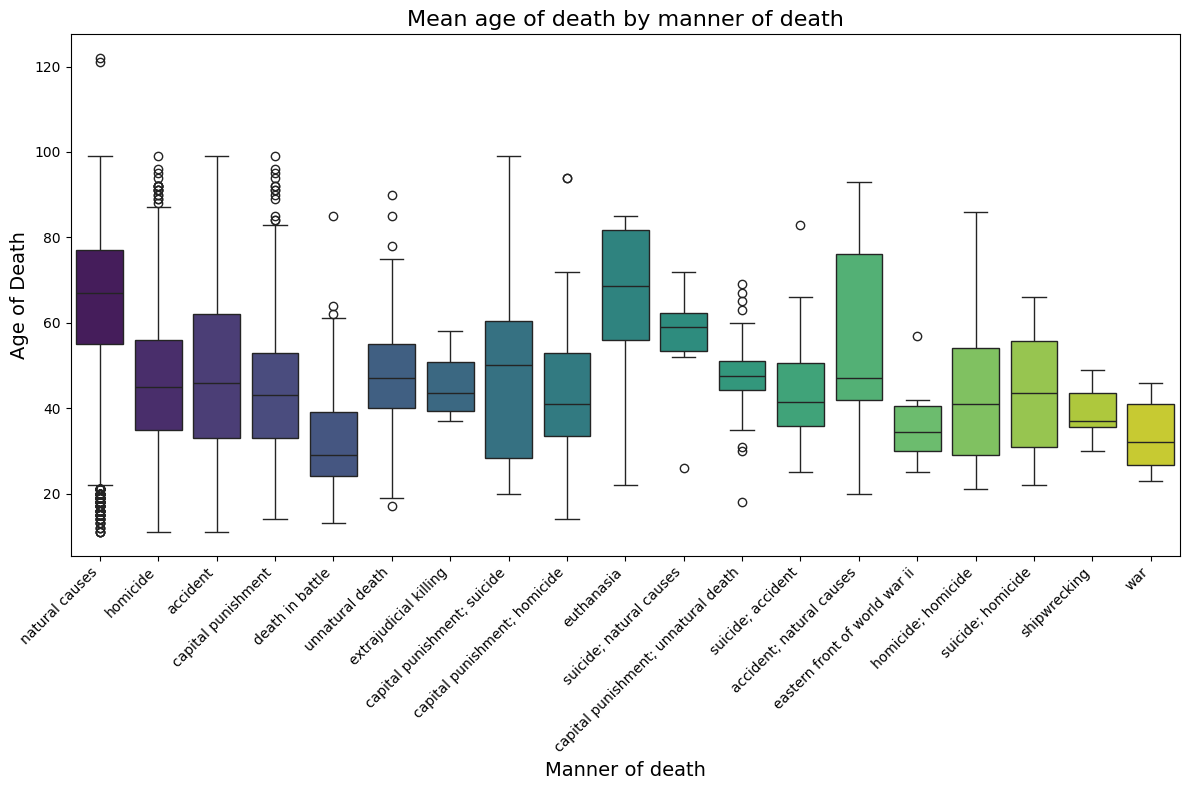

In [59]:
# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(x='Manner of death', y='Age of death', data=filtered_data, palette='viridis')

# Adding titles and labels
plt.title('Mean age of death by manner of death', fontsize=16)
plt.xlabel('Manner of death', fontsize=14)
plt.ylabel('Age of Death', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
fig = plt.gcf() # get current figure
plt.show()

In [ ]:
# save figure
fig.savefig('/work/datascience_exam/output/plots/mean_age_manner_of_death.jpg')

### Age of death
The outcome variable, which we seek to predict.

In [36]:
data_other = data[data['Gender_encode'] == 3]

In [37]:
data_other

,Gender,Country,Occupation,Birth year,Age of death,Short description,Gender_encode
892,Transgender Female,united states of america,researcher,1949,49.0,american game designer and programmer,3
4837,Intersex,germany,athlete,1918,90.0,german high jumper,3
13091,Transgender Female,united states of america,artist,1944,67.0,artist,3
22359,Transgender Person; Intersex; Transgender Male,germany; israel,artist,1885,71.0,germanisraeli author social worker reformer su...,3
34307,Transgender Female,united states of america,artist,1950,37.0,american actress,3
...,...,...,...,...,...,...,...
1158441,Transgender Male,brazil,artist,1950,68.0,brazilian transgender writer,3
1159524,Transgender Female,czech republic,journalist,1965,55.0,czech journalist,3
1170804,Transgender Female,united kingdom,activist,1954,65.0,british transgender activist,3
1192190,Transgender Female,chile,hairdresser; vedette,1949,62.0,first transgender woman that had a sex reassig...,3


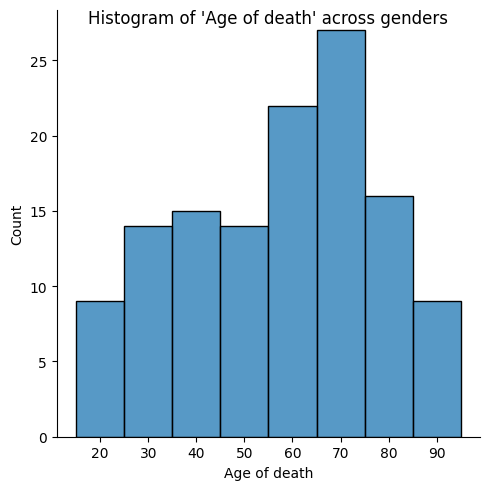

In [38]:
sns.displot(data = data_other, x= 'Age of death', kind = 'hist')
plt.title("Histogram of 'Age of death' across genders", y = 0.95)
fig = plt.gcf()
plt.show()

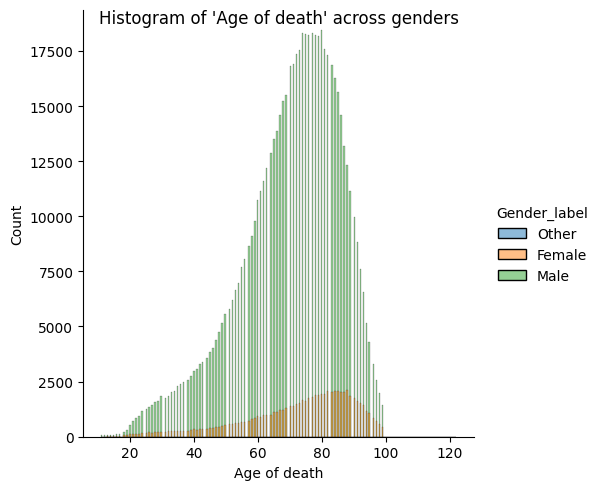

In [30]:
sns.displot(data = data, x= 'Age of death', hue = 'Gender_label', kind = 'hist', hue_order = ['Male', 'Female', 'Other'])
plt.title("Histogram of 'Age of death' across genders", y = 0.95)
fig = plt.gcf()
plt.show()

In [26]:
# save fig
fig.savefig('/work/datascience_exam/output/plots/age_of_death_histogram.jpg')

/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_50583/2710900680.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["Male", "Female", "Other"])


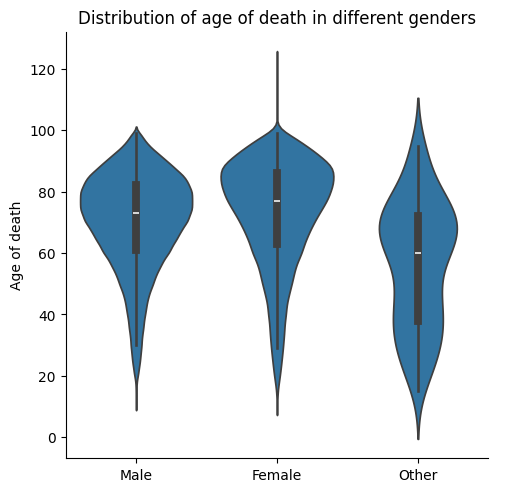

In [45]:
#sns.catplot(data=tips, kind="violin", x="day", y="total_bill", hue="smoker", split=True)
sns.catplot(data=data, kind = 'violin', x = 'Gender_encode', y = 'Age of death')#, hue = "Gender_encode")#, split = True)

plt.gca().set_xticklabels(["Male", "Female", "Other"])
plt.gca().set_title('Distribution of age of death in different genders')
plt.gca().set_xlabel('')

plt.show()

In [46]:
# For fun
data_ar_pol = data[data['Occupation'].isin(["politician", "artist"])]
#data_ar_pol = data_ar_pol[data_ar_pol['Gender_encode'].isin([1, 2])]
data_ar_pol.head()
data_ar_pol['Occupation'].value_counts()
data_ar_pol['Gender_encode'].value_counts()

Gender_encode
1    315502
2     45230
3        69
Name: count, dtype: int64

/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_50583/472536192.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["Male", "Female", "Other"])


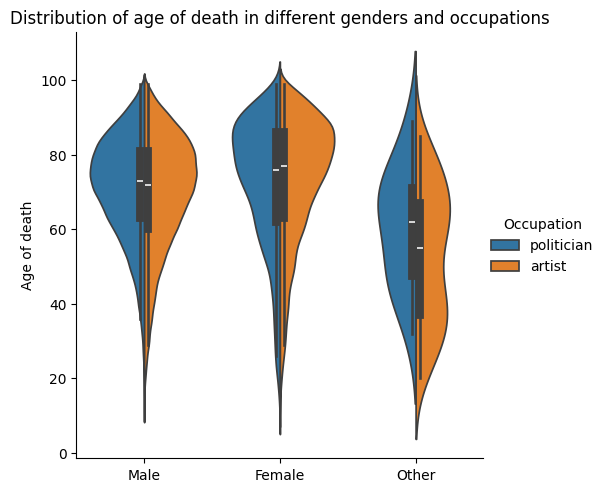

In [47]:
#sns.catplot(data=tips, kind="violin", x="day", y="total_bill", hue="smoker", split=True)
sns.catplot(data=data_ar_pol, kind = 'violin', x = "Gender_encode", y = 'Age of death', hue = "Occupation", split = True)

plt.gca().set_xticklabels(["Male", "Female", "Other"])
plt.gca().set_title('Distribution of age of death in different genders and occupations')
plt.gca().set_xlabel('')

plt.show()

# splitting data into training, validation and test 

In [42]:
# rearranging the order of columns and filtering out 'Gender'
data = data[["Gender_encode", "Birth year","Country", "Occupation", "Short description", "Age of death"]]

In [43]:
data.head()

,Gender_encode,Birth year,Country,Occupation,Short description,Age of death
0,1,1732,united states of america; kingdom of great bri...,politician,st president of the united states,67.0
1,1,1952,united kingdom,artist,english writer and humorist,49.0
2,1,1809,united states of america,politician,th president of the united states,56.0
3,1,1756,archduchy of austria; archbishopric of salzburg,artist,austrian composer of the classical period,35.0
4,1,1770,holy roman empire; austrian empire,artist,german classical and romantic composer,57.0


In [44]:
data.iloc[:, :5]

,Gender_encode,Birth year,Country,Occupation,Short description
0,1,1732,united states of america; kingdom of great bri...,politician,st president of the united states
1,1,1952,united kingdom,artist,english writer and humorist
2,1,1809,united states of america,politician,th president of the united states
3,1,1756,archduchy of austria; archbishopric of salzburg,artist,austrian composer of the classical period
4,1,1770,holy roman empire; austrian empire,artist,german classical and romantic composer
...,...,...,...,...,...
1222992,1,1930,kingdom of the netherlands,athlete,dutch swimmer
1222993,1,1784,scotland,goldsmith,goudsmid uit schotland
1223000,1,1857,switzerland,entrepreneur,entrepreneur from switzerland
1223007,1,1887,united kingdom,artist,english artist working in stained glass printm...


In [46]:
X = data.iloc[:,:5].values # all rows, column 1 to (not incl) 5
y = data.iloc[:,5].values # all rows, column 5
# OBS on correct number!

In [47]:
# split data into train and test using scikitlearn
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)


# let's further split the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

In [49]:
# save data
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df.columns = data.columns
    #df.to_csv(f'data/{name}.csv')
    df.to_csv(f'../../data/{name}.csv')